# An Introduction to Dynamic Mode Decomposition (DMD)

This notebook introduces the basics of Dynamic Mode Decomposition (DMD). Some other great tools for learning are:

> [Dynamic Mode Decomposition in Python](http://www.pyrunner.com/weblog/2016/07/25/dmd-python/) from pyrunner

> [Data Driven Science and Engineering](https://www.cambridge.org/core/books/datadriven-science-and-engineering/77D52B171B60A496EAFE4DB662ADC36E) by Steven L. Brunon and J. Nathan Kutz

# DMD at a Glance

## Goal
The goal of DMD is to approximate the leading eigencomposition of (high dimensional) linear operator $A \in \mathbb{C}^{n \times n}$, where $X'=AX$, to find spacial temporal coherant structures of a given (possibly non-linear) system. Simply put:
> "DMD converts a dynamical system into a superposition of modes whose dynamics are governed by eigenvalues." -[pyrunner](http://www.pyrunner.com/weblog/2016/07/25/dmd-python/)
## Inputs
The following data pair $X$ and $X'$ contain snapshots of data, for example a fluid flow. Here, $n$ is the number of spatial points saved per shot and $m$ is the number of snapshots taken.

- Snapshot (long and skinny) $X = 
 \begin{bmatrix}
  \vert & \vert &     & \vert \\
  x_1   & x_2   & ... & x_{m-1} \\
  \vert & \vert &     & \vert
 \end{bmatrix} \in \mathbb{C}^{n \times (m-1)}$

- Snapshot evolved by one unit in time $X' = 
 \begin{bmatrix}
  \vert & \vert &     & \vert \\
  x_2   & x_3   & ... & x_{m} \\
  \vert & \vert &     & \vert
 \end{bmatrix} \in \mathbb{C}^{n \times (m-1)}$
 
Recall: $X'=AX$. Linear operator $A$ therefore advances the system state $X$ one step forward in time $X'$.

## Steps
**1. Compute Singular Value Decomposition (SVD) of big data matrix $X$ to find the dominant coherent structures (Columns of $U$).**

The singular value decomposition of snapshot $X$ gives us the left singular vectors $U$, the singular values $\Sigma$, and the right singular vectors $V$. These results can be truncated when, for example, 99% of the system energy is captured by the first $r$ comumns of $U$. The $\dagger$ here stands for complex conjugate transpose (see _Linear Algebra Basics Notebook_).

$$ X = U\Sigma V^{\dagger} $$

**2. Project $A$ on the columns of $U$ to get the reduced dynamic operator $\tilde{A}$**

Replacing $X$ in $X' = AX$ with our SVD results gives us $ X' = AU\Sigma V^{\dagger} $. Instead of doing a (very demanding) pseudo-inverse to find the full matrix $A$, we project $A$ onto the dominant singluar vectors of $U$. Reduced matrix $\tilde{A}$, which is only of the magnitude of time, is a linear best fit dynamical system that tell us how the dominant coherant structures of the system evolve over time.

$$U^{\dagger}X'V\Sigma^{-1} = U^*AU = \tilde{A}$$

**3. Compute the eigenvalues $\Lambda$ and eigenvectors $W$ of $\tilde{A}$**

$\tilde{A}$ has the same non-zero *eigenvalues* as $A$. We can therefore obtain the eigenvalues $\Lambda$ of $A$ from the eigendecomposition of $\tilde{A}$:

$$\tilde{A}W = W\Lambda$$

**4. Compute the eigenvectors $\Phi$ of $A$**

The eigenvectors $\Phi$, also called *DMD modes*, are found using the following relationship:

$$\Phi = X'V\Sigma^{-1}W$$

## Application
With our (spacial) modes $\Phi$ and (temporal) eigenvalues $\Lambda$, we can analyse a system or predict (to a certain extent) what that system will do in the future. $X' = AX$ can be written as a continuous function in time $\hat{X}(t) = \Phi\Lambda^{t/\Delta t}b_0$, where $\hat{X}$ is predicted state of the system based on the DMD modes and eigenvalues, which make up the right side of the equation.

These steps and applications of DMD are explained in futher detail in the following examples.

# Simple DMD Example

In the following, a short example of a DMD will be presented using artificial data. For this introduction, we will use PyTorch for the linear algebra tasks and Matplotlib for plotting.

In [1]:
import matplotlib.pyplot as plt

import torch as pt
import numpy as np #see 'Building Reduced Matrix A_tilde'

from plotting_functions import plot_data, plot_singular_values, plot_eigenvalues, plot_dmd_modes, plot_psi_in_time, recon_data_from_DMD, plot_data_matrix_image, plot_recon_img, plot_sing_val_and_function

pt.__version__

'1.8.0'

### Meshgrid
We start by creating a small meshgrid for the discretization of our data.

*Note: The inputs of Pytorch.meshgrid(t,x) are flipped compared to numpy.meshgrid(x,t). See [documentation](https://pytorch.org/docs/master/generated/torch.meshgrid.html).*

*Note: PyTorch has no built in Pi-Function. See [forum post](https://discuss.pytorch.org/t/np-pi-equivalent-in-pytorch/67157).*

In [2]:
pt.pi = pt.acos(pt.zeros(1)).item()*2  #PyTorch has no built in Pi function

x_start=-10
x_end=10
n_x=100
t_start=0
t_end=6*pt.pi
n_t=80

x = pt.linspace(x_start, x_end, n_x)
t = pt.linspace(t_start, t_end, n_t)

Tm, Xm = pt.meshgrid(t, x)

### Functions
Our artificial data is generated from the following functions $f_1$, $f_2$, and $f_3$, with a decreasing frequency.

The temporal changes are visualized by a decreasing of the opacity. Therefore, $𝑡_0$ is darkest, with the opacity decreasing with every time increment.

The colors of each function will aid the comparisions of the DMD modes and eigenvalues later on.

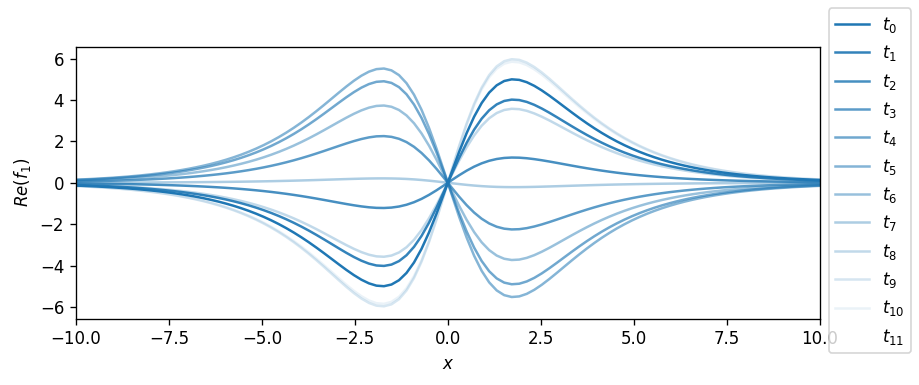

In [3]:
f1 = pt.multiply(10*pt.tanh(Xm/2)/pt.cosh(Xm/2), pt.exp((0.1+2.8j)*Tm)).T   #Im: frequency = 2.8
                                                                            #Re: amplitude = increasing
plot_data(f1, 1)

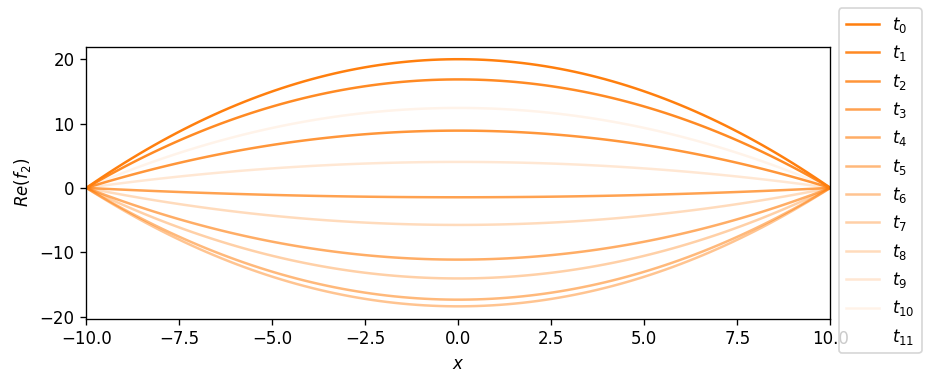

In [4]:
f2 = pt.multiply(20-0.2*pt.pow(Xm, 2), pt.exp((-0.05+2.3j)*Tm)).T    #Im: frequency = 2.3
                                                                     #Re: amplitude = decreasing
plot_data(f2, 2)

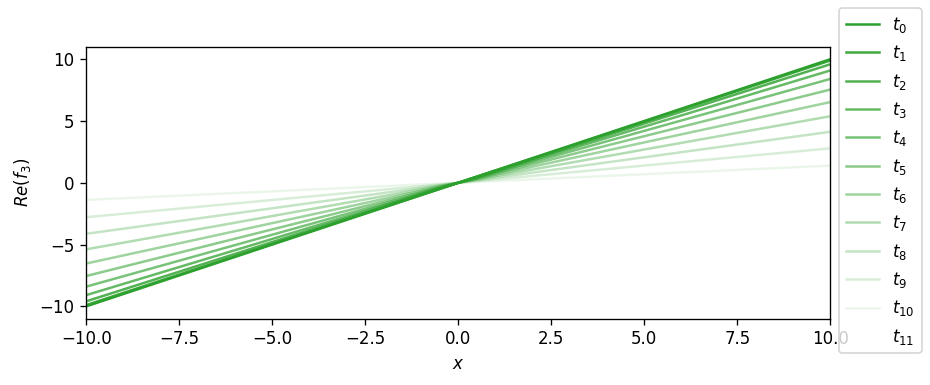

In [5]:
f3 = pt.multiply(Xm, pt.exp(0.6j*Tm)).T     #Im: frequency = 0.6
                                            #Re: amplitude = const.
plot_data(f3, 3)

### Combining Data
The signals of our functions are combined into one data matrix. This "raw" data is equivalent to data obtained experimentally for real world DMD applications. Our $X$ and $X'$ snapshots are created to serve as our DMD input matrices.

Again: $t_0$ is darkest, with the opacity decreasing with time.

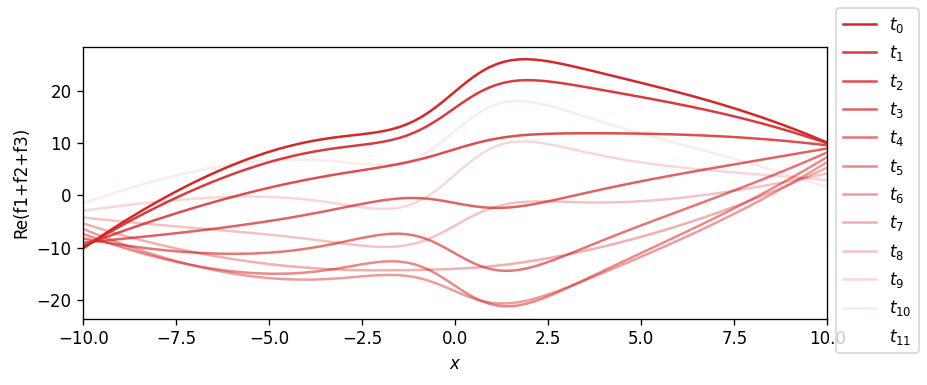

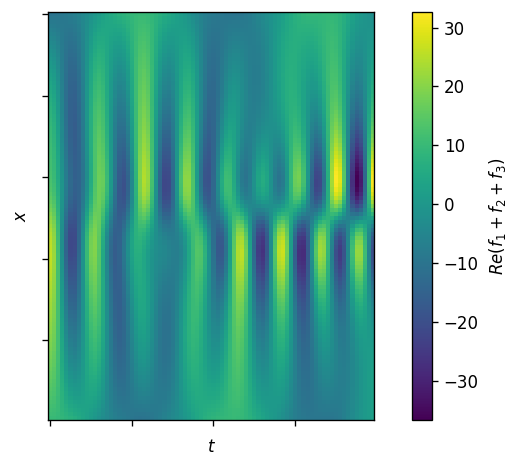

In [6]:
'''Creating artificial data'''
data = f1 + f2 + f3

plot_data(data, 4)
plot_data_matrix_image(data, 'f_1+f_2+f_3') #alternative visualisation

#Create our two data snapshots X and X'
X = data[:,:-1]
X_prime = data[:,1:]

### Singular Value Decomposition (SVD)

The following function is defined to compute the SVD of $X$, the first step of DMD.

*Note: pt.linalg.svd() is new in PyTorch 1.8, so make sure update the package.*

In [7]:
'''
Calculating singular value decomposition

        Returns:
                U_temp (unitary matrix): columns are called left singular vectors
                s_temp (tensor): real, nonnegative diagonal elements of Sigma
                Vt_temp (matrix): complex conjugate transpose of V. Columns of V are called right singular vectors
'''
U_temp, s_temp, Vt_temp = pt.linalg.svd(X)

### Truncating

Columns of U are the dominant coherant structures, or POD modes. For more on Proper Orthogonal Deconposition, check out the *POD notebook*.

The diagonal elements of $\Sigma$ are singualar values, ordered from largest to smallest (for fluids, from high-energy to low). We can easily graph these (small order: $s \in \mathbb{C}^{m}$) to determine which ones are relevant to our data. For noisy, real world data with no non-zero singular values, hard-thresholding algorithms are applied. Check out the *Multiresolution DMD* to learn more about this.

For this example, we can easily see that all of our data is represented by only three modes. This shouldn't be suprising, since we created the data from three functions. We therefore keep three modes and truncate the rest. By reducing the dimensionality of our system, we potentially save a lot of processing power during the following DMD steps.

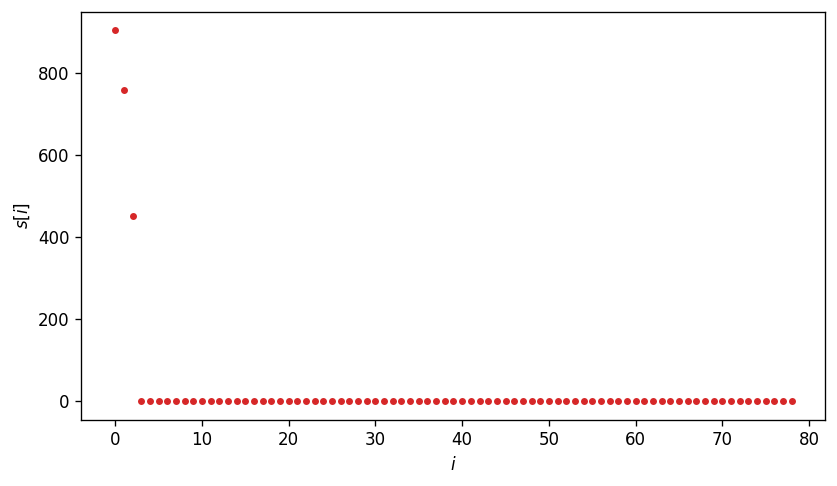

In [8]:
'''Plotting singular values'''
plot_singular_values(s_temp)

'''Truncating'''
rank = 3

U = U_temp[:,:rank]
s = s_temp[:rank]
V = Vt_temp.conj().T[:,:rank]     #<--- complex conjugate transpose to get V

### Building Reduced Matrix $\tilde{A}$

After finding the SVD of our input data matrix $X$, we can build the reduced matrix $\tilde{A} = U^{\dagger}X'V\Sigma^{-1}$ using the results.

*Note: $\Sigma$ is a diagonal matrix and can therefore be inversed using 1/diag_elements.*

In [9]:
s_inv = pt.diag(1.0/s).type(pt.complex64) #type cast since Sigma is only real
    
A_tilde = U.conj().T @ X_prime @ V @ s_inv

## Eigenvalues $\Lambda$

Reduced matrix $\tilde{A}$ shares the same eigenvalues with full matrix $A$. Therefore, computing the much quicker eigendecomposition of $\tilde{A}W = W\Lambda$ results in the correct eigenvalues $\Lambda$ of full matrix $A$. For more on the matrix decomposition, check out the _Linear Algebra Notebook_. 

Graphing the resulting eigenvalues leads to some insightful information on the behavior of the respective DMD mode. $Im(\lambda)\neq 0$ corresponds to an oscillating DMD mode. The location of the eigenvalue within, on, or outside of the unit circle determines if the mode is growing or decaying. The behavior of the modes for our example can therefore be determined as follows: $\lambda_1$ is oscillating the most and growing, $\lambda_2$ is oscillating and decaying, and $\lambda_3$ is oscillating the least and neither growing nor decaying. This behavior matches our expectations, since we created the functions $f_1, f_2, f_3$ with these characteristics (see [comments](#Functions) in code).

*Note: Since Pytorch 1.8 does not currently support complex tensor operations (see [forum](https://discuss.pytorch.org/t/how-to-use-complex-eigenvalues/71983)), we will use np.linalg.eig() for this example.*

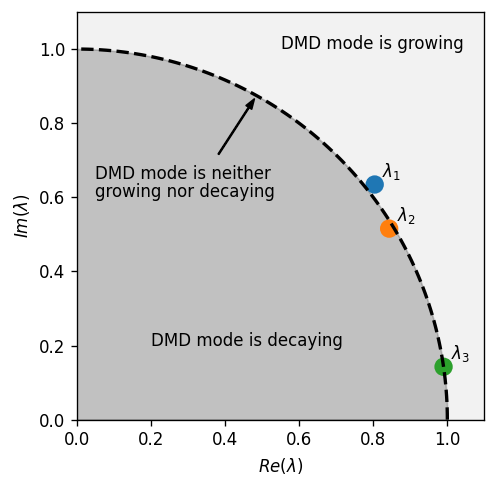

In [10]:
'''Calculating eigenvalues'''
val, vec = np.linalg.eig(A_tilde) #not supported in pytorch 1.8

val = pt.from_numpy(val) #simple conversion to continue working with PyTorch Tensors
vec = pt.from_numpy(vec)


'''Plotting eigenvalues'''
plot_eigenvalues(val)

## Eigenvectors (modes) $\Phi$

Finding the exact DMD modes $\Phi = X'V\Sigma^{-1}W$ of full matrix $A$ is the last step of the dynamic mode decomposition. These spacial temporal coherant structures give us an insight as to how the the system is behaving on a fundamental level. The similarity of these modes $\Phi_1$, $\Phi_2$, $\Phi_3$ with our original data functions $f_1$, $f_2$, $f_3$ should be apparant. The colors have been matched to further illustrate the similarity.

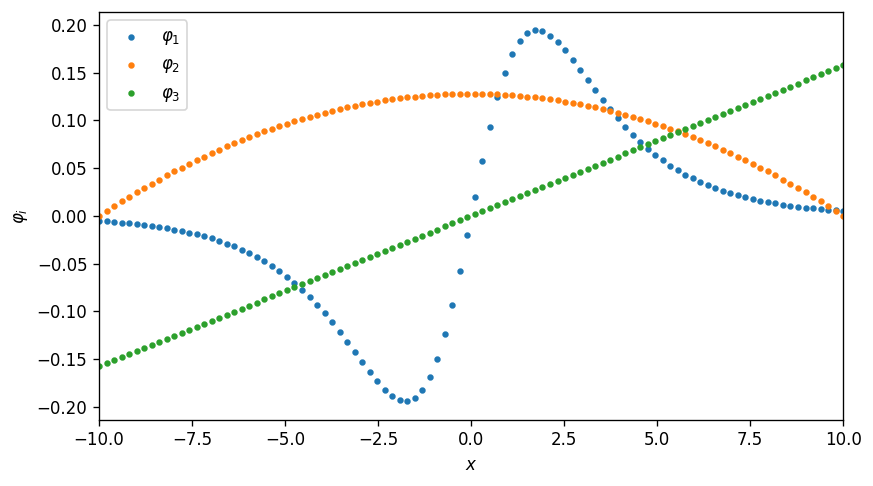

In [11]:
'''Calculating eigenvectors'''
phi = X_prime @ V @ s_inv @ vec #exact DMD modes


'''Plotting eigenvectors'''  
plot_dmd_modes(Xm[0,:], phi)

# Now what?

With the (spacial) modes $\Phi$ and (temporal) eigenvalues $\Lambda$ we found using DMD, we can create an explicit function to model the time dynamics of the system. We can therefore create a _continuous_ function using only the _discrete_ snapshots of data we had at the beginning.

$$\psi = \Lambda^{t/\Delta t}b$$

- $\psi$ is a matrix corresponding to the system's time evolution
- $\Lambda$ is our eigenvalues
- $\Delta t$ is the time step from the discretization we used at the beginning of the DMD
- $b = \Phi^\dagger X_0$ is the amplitude of our modes, or a condition for how much each mode is expressed in the data

All three plots are oscillating, as previously indicated by the imaginary parts of our eigenvalues. Additionally, the growing of $\psi_1$, decaying of $\psi_2$, and constance of $\psi_3$ corresponds with our expectations from graphing the eigenvalues.

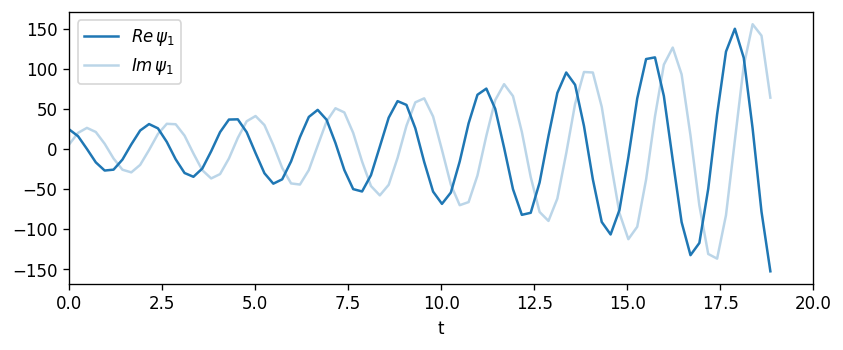

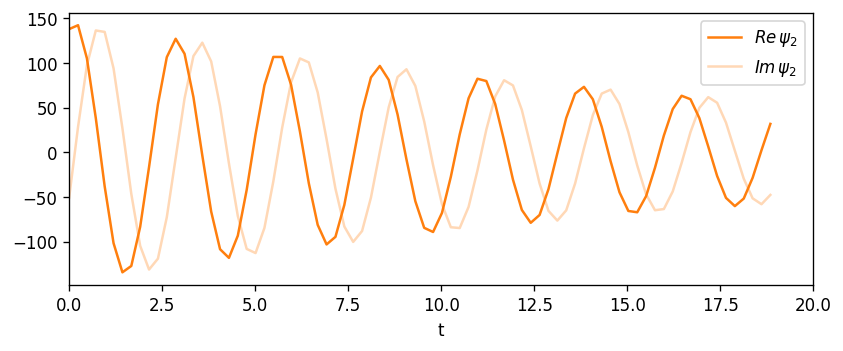

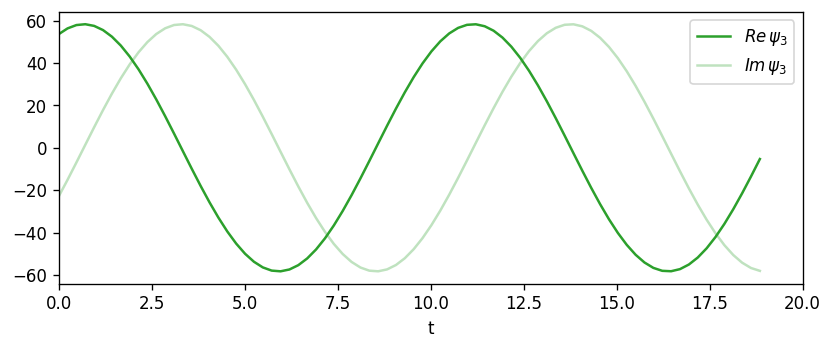

In [12]:
'''Construct function for time dynamics'''
dt = (Tm[2,0] - Tm[1,0]) #delta t

b = (pt.pinverse(phi) @ X[:,0]).T #factor for modes
psi = pt.zeros(rank, len(Tm), dtype=pt.complex64)
for i, t_temp in enumerate(t):    
    psi[:,i] = pt.multiply(pt.pow(val, t_temp/dt), b) #time dynamics
    
plot_psi_in_time(psi, 1)
plot_psi_in_time(psi, 2)
plot_psi_in_time(psi, 3)

## Reconstructing Data

Taking the dot product of our spacial modes $\phi$ with our temporal matrix $\psi$, we can construct a predicted state $\hat{X}$ based on the DMD results and compare this with the original data $X$ we created at the beginning of this tutorial. Graphing the reconstructed data (purple), we can see that we have successfully recreated the original data (red). This therefore legitimizes our reconstructed data.

$$\hat{X}(t) = \Phi\Lambda^{t/\Delta t}b = \Phi\cdot\psi$$

- $\Phi$ is our exact DMD modes
- $\psi$ is our time dynamics

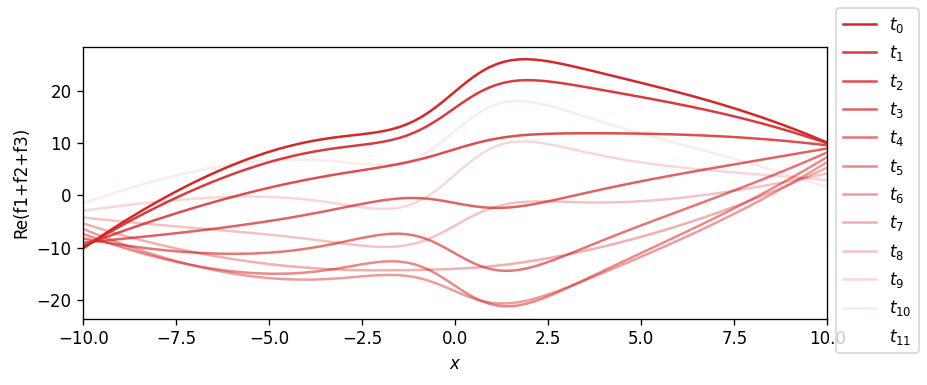

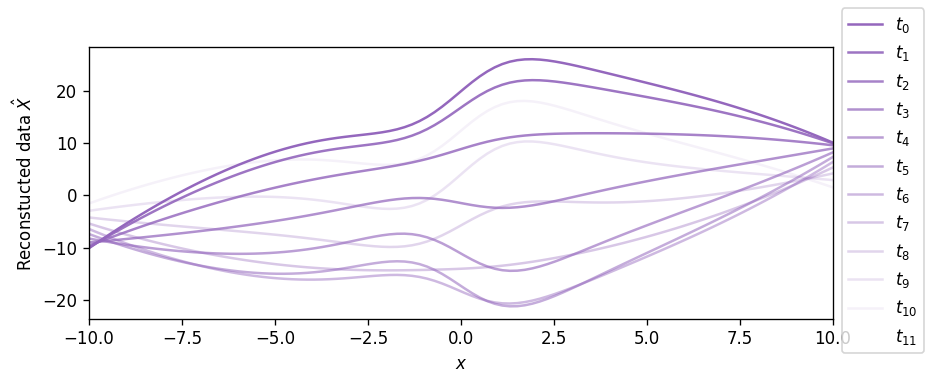

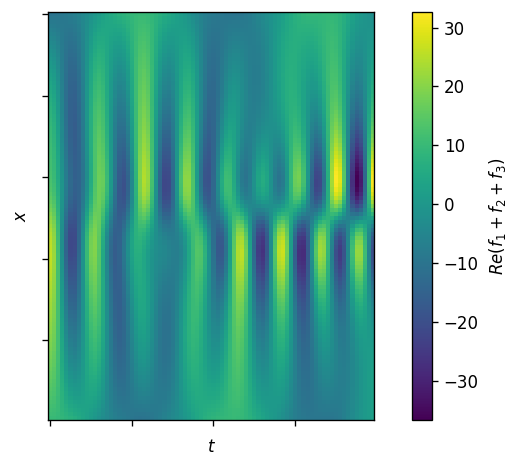

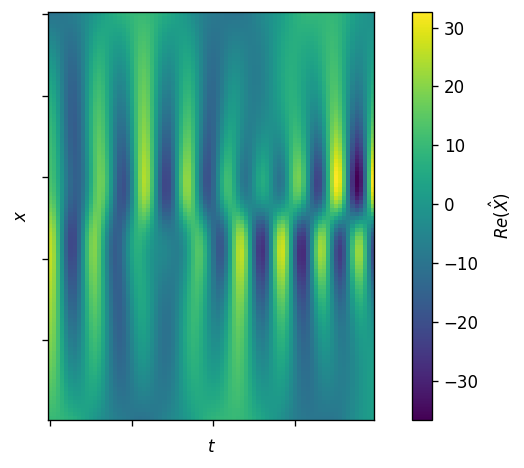

True


In [13]:
'''Original Data '''
data                                 #recall: data = (f1 + f2 + f3)
plot_data(data, 4)

'''Reconstructed Data'''
data_reconstructed = phi @ psi       #X_hat
plot_data(data_reconstructed, 5)

'''Another Comparison'''
plot_data_matrix_image(data, 'f_1+f_2+f_3')
plot_data_matrix_image(data_reconstructed, '\hat{X}')

print(pt.allclose(data, data_reconstructed, atol=1e-03)) #nur True bei einer sehr geringen Tolerance... ist das richtig?

## Predicting future states

We can now simulate a given initial condition $X_0$ forward in time. Our original data matrices $X$ and $X'$ are limited in size by the discretization we performed. They each contain $6\pi$ seconds of data. If we want to know what the system is doing at a time point beyond the $6\pi$, we can use the function $\psi$ to get future predicted states $\hat{X}$ of the system.

# THIS IS THE LAST THING TO FIX

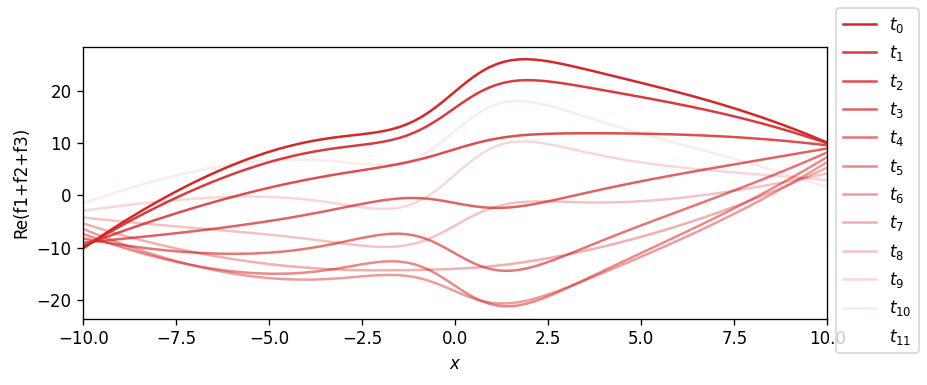

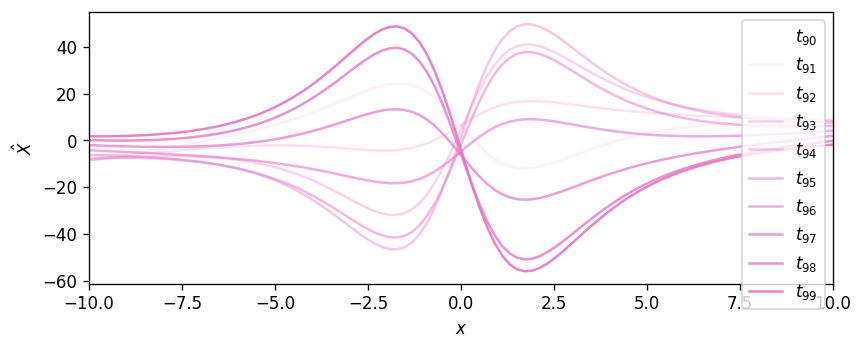

In [61]:
b = (pt.pinverse(phi) @ X[:,0]).T

psi2 = pt.zeros(rank, len(Tm), dtype=pt.complex64)
for i, t_temp in enumerate(t):    
    psi2[:,i] = pt.multiply(pt.pow(val, t_temp/dt), b)
X_dmd = phi @ psi2

#DMD BOOK
#no additional work is required for the future state prediction besides plugging the desired future time into (1.24)
#page 21

plot_data(data, 4)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
for i in range(10):
    ax.plot(Xm[0,:], pt.real(X_dmd[:,90+i]), c='C6', alpha = i/10, label='$t_{{{}}}$'.format(90+i))
ax.set_xlabel(r"$x$")
ax.set_ylabel('$\hat{X}$')
ax.set_xlim(pt.min(Xm[0,:]), pt.max(Xm[0,:]))
ax.legend(loc=1)
fig.show()

## Reconstructing Original Snapshots

finale zeitsignal reconstuieren und snapshots (vom anfang) vergleichen


erste spalte von phi und lambda wert und b -> spalte für reconstruieren (einzelne moden sehen)


rechte seite wichtet moden unterschiedlich fuer jeden zeitpunkt




was passiert wenn mode 1 vollstandig rekonstruieren

einzelne moden und zeitsignal um mode uber zeit zu animieren

# Limitations

See DMD Book for more challenges.

## Invariances

DMD is based on the SVD of $X$, the spacio-temporal data matrix, which brings with it a seperation of variables; spatial modes given by columns of $U$ and time dynamics given by columns of $V$. This space-time separation results in known weaknesses in handeling translational/rotational invariances in the data.

An example of a translational invariance is given in the following. The steps of DMD and reconstruction of the temporal function as well as the plotting are condensed into one method, since they were previously explained. We create data from the function $f_4(x,t) = e^{(x-t+5)^2}$, which has translational invariance.

The singular values in red and the original spacial temporal image are shown below. The data was truncated between $rank=2$ and $rank=12$ after the SVD. Here, each plot represents a superposition of that number of modes. For this example, nearly 12 DMD modes are needed to accurately reconstruct the original system dynamics $\hat{f_4}$, even though our initial data was created from only one function $f_4$.

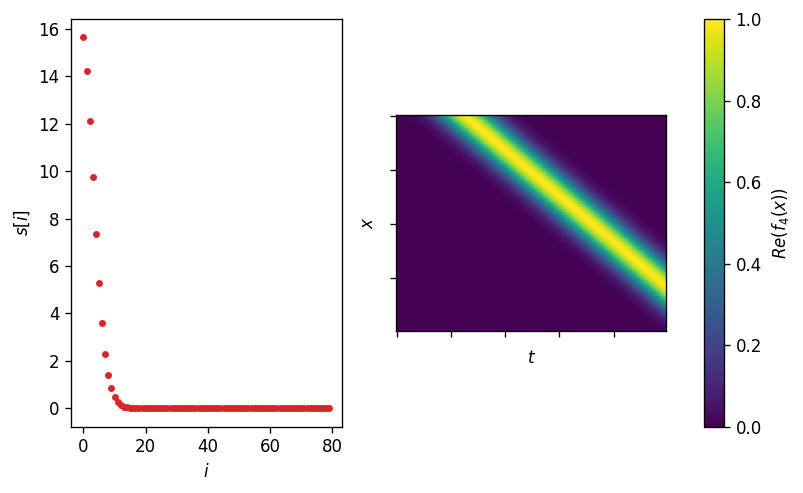

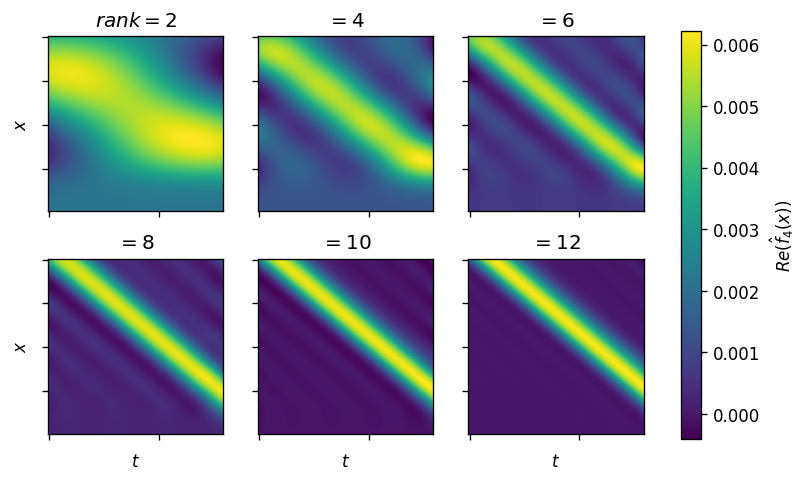

In [15]:
t = pt.linspace(0, 6*pt.pi, 80)
x = pt.linspace(-10, 10, 100)
Tm, Xm = pt.meshgrid(t, x)
dt = t[2]-t[1]

'''new function with translational invariance'''
f4 = pt.exp(-pt.pow((Xm-Tm+5)/2, 2)).type(pt.complex64)

'''singular values are graphed to determine rank'''  
plot_sing_val_and_function(f4, '4')
    
'''dmd is performed with truncation at various ranks'''
plot_recon_img(f4, 6)

## Transient Time Phenomena

Data that is time transient is also not accurately decomposed by DMD. We repeat the steps above for $f_5(x,t) = e^{-(\frac{x}{4})^2} * e^{-(\frac{t-5}{2})^2}$, a transient function. Since the DMD (correctly) identifies only one significant mode, we truncate with $rank=1$ after the SVD. However, this mode, and therefore the reconstructed function $\hat{f_5}$, does not match the original spacial temporal evolution of the system $f_5$.

_Note: Multi-resolution DMD offers a solution to intermittent phenomena._

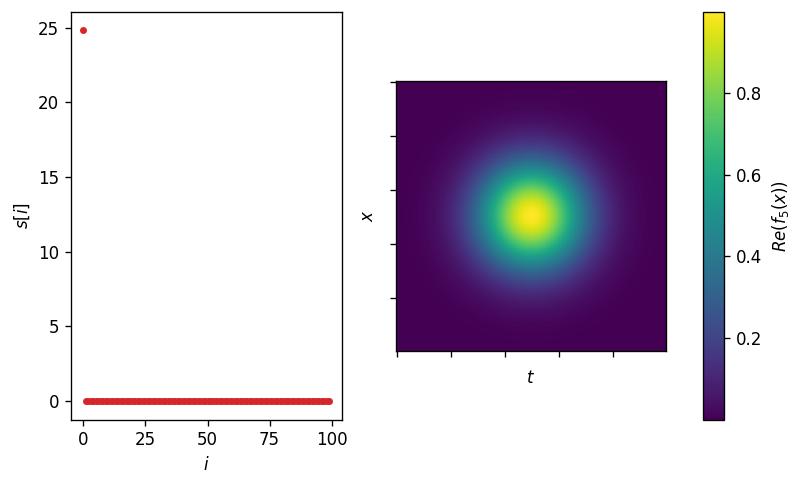

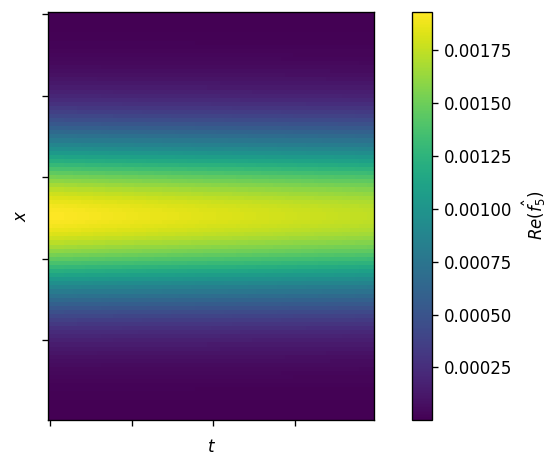

In [16]:
t = pt.linspace(0, 10, 100)
x = pt.linspace(-10, 10, 100)
Tm, Xm = pt.meshgrid(t, x)
dt = t[2]-t[1]

'''new function with time transience'''
f5 = pt.exp(-pt.pow((Xm)/4, 2)) * pt.exp(-pt.pow((Tm-5)/2, 2)).type(pt.complex64)
    
'''singular values are graphed to determine rank'''    
plot_sing_val_and_function(f5, '5')

'''dmd is performed only once with rank=1'''
f5_hat = recon_data_from_DMD(f=f5, r=1)

'''resulting DMD mode is visualized'''
plot_data_matrix_image(f5_hat, '\hat{f_5}')

## References

1. Brunton, S., & Kutz, J. (2019). *Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control.* Cambridge: Cambridge University Press.
2. Kutz, J. N., Brunton, S. L. 1., Brunton, B. W., & Proctor, J. L. (2016). *Dynamic Mode Decomposition.* Philadelphia, PA, USA: Society for Industrial and Applied Mathematics.
3. Taylor, R. (2016) Dynamic Mode Decomposition in Python. *Pyrunner.* Accessed: 25 January 2021. http://www.pyrunner.com/weblog/2016/07/25/dmd-python/
4. [dmdbook.com](http://dmdbook.com/)
5. [Steve Brunton YouTube Channel](https://www.youtube.com/watch?v=sQvrK8AGCAo&t=611s&ab_channel=SteveBrunton)

## Questions:

- remove legend for time, is it too much? (opacity changing)

- would a DMD of LES data give us the approximate behavior of the different size eddies? Small eddies should equal the behavior modeled by the turbulenz models'

- Reconstructing data: pt.allclose doesn't always work

- should $\psi$ be $\omega$ (like in example code) for the function for the time dynamics of the modes

- how should all the plotting functions be imported? okay in one long line?

- Am I hiding too much of the code in the plotting file?